# VAE Chinese glyphs explorer

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1) # Output size: [32, 64, 64]
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # Output size: [64, 32, 32]
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1) # Output size: [128, 16, 16]
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1) # Output size: [256, 8, 8]
        self.conv5 = nn.Conv2d(256, 512, 4, stride=2, padding=1) # Output size: [512, 4, 4]
        
        # Latent vectors mu and logvar
        self.fc1 = nn.Linear(512*4*4, 1024)
        self.fc_mu = nn.Linear(1024, 256)
        self.fc_logvar = nn.Linear(1024, 256)

        # Decoder
        self.fc2 = nn.Linear(256, 512*4*4)
        self.conv6 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)
        self.conv7 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.conv8 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.conv9 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.conv10 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

    def encode(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.relu(self.conv5(h))
        h = h.view(-1, 512*4*4)
        h = F.relu(self.fc1(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        h = h.view(-1, 512, 4, 4)
        h = F.relu(self.conv6(h))
        h = F.relu(self.conv7(h))
        h = F.relu(self.conv8(h))
        h = F.relu(self.conv9(h))
        return torch.sigmoid(self.conv10(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [2]:
# Initialize model
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Initialize dataloader
class ChineseCharacterDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_names = os.listdir(folder_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(),  # Convert to monochrome
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.file_names[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        return image

dataset = ChineseCharacterDataset('data128')
# data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Train-test split
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% of the dataset for training
test_size = total_size - train_size  # Remaining 20% for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)

Run a training loop

Epoch 0, Training Loss: -90671.27342028468, Test Loss: -100278.61529299666
Epoch 1, Training Loss: -103393.44434518492, Test Loss: -109275.37541686518
Epoch 2, Training Loss: -116377.798582574, Test Loss: -122830.84468794664
Epoch 3, Training Loss: -128442.35221249479, Test Loss: -135754.43425440686
Epoch 4, Training Loss: -139467.58525400513, Test Loss: -142050.86326822295
Epoch 5, Training Loss: -149002.804835924, Test Loss: -154221.18556455456
Epoch 6, Training Loss: -157206.99446131857, Test Loss: -160312.06074321104
Epoch 7, Training Loss: -164196.04407122862, Test Loss: -167473.20581229156
Epoch 8, Training Loss: -169813.28616520754, Test Loss: -172341.7422582182
Epoch 9, Training Loss: -175740.38568280626, Test Loss: -174211.17579799905
Epoch 10, Training Loss: -181509.94127806564, Test Loss: -182075.0952834683
Epoch 11, Training Loss: -186056.99767732713, Test Loss: -184413.25011910434
Epoch 12, Training Loss: -190636.63724614377, Test Loss: -188915.72129585518
Epoch 13, Traini

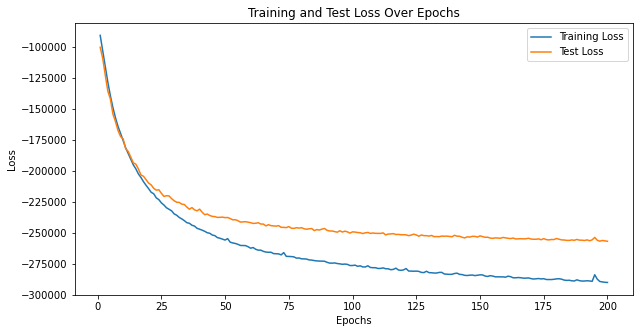

In [10]:
# Create 'saved_models' directory if it doesn't exist
saved_models_dir = 'saved_models'
if not os.path.exists(saved_models_dir):
    os.makedirs(saved_models_dir)

# Initialize loss tracking
train_losses = []
test_losses = []

# Set the number of epochs
num_epochs = 200  # Example, set this as needed

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation (test) phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            test_loss += loss_function(recon, data, mu, logvar).item()
    
    # Calculate average test loss
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f"Epoch {epoch}, Training Loss: {train_loss}, Test Loss: {test_loss}")

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
        save_path = os.path.join(saved_models_dir, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), save_path)

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

Check the reconstructions

In [3]:
def show_reconstructions(model, data_loader, num_images=6):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        # Get a batch of images
        for batch in data_loader:
            batch = batch.to(device)
            recon, _, _ = model(batch)
            break  # We only need one batch

    batch = batch.cpu()
    recon = recon.cpu()

    fig, axs = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Display original images
        axs[0, i].imshow(batch[i].reshape(128, 128), cmap='gray')
        axs[0, i].set_title(f"Original {i+1}")
        axs[0, i].axis('off')

        # Display reconstructed images
        axs[1, i].imshow(recon[i].reshape(128, 128), cmap='gray')
        axs[1, i].set_title(f"Reconstructed {i+1}")
        axs[1, i].axis('off')

    plt.show()

# Assuming you already have your model and data_loader
# show_reconstructions(model, test_loader, num_images=6)

Load a saved model 

Loading model on: cuda


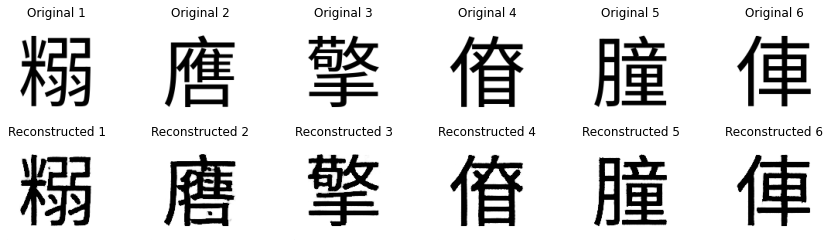

In [4]:
def load_model(model_path, model_architecture):
    """
    Loads a model from the specified path onto the GPU.

    Args:
    model_path (str): Path to the .pth file of the saved model.
    model_architecture (nn.Module): The architecture of the model (should match the saved model).

    Returns:
    The loaded model.
    """
    if not os.path.isfile(model_path):
        print(f"Model file not found: {model_path}")
        return None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Loading model on: {device}")

    model = model_architecture().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

# Example usage
model_path = './saved_models/model_epoch_200.pth'
loaded_model = load_model(model_path, VAE)

# Do something with loaded_model
show_reconstructions(loaded_model, test_loader, num_images=6)

TODO: clean up notebook

In [5]:
# # Make torchviz visualization of VAE architecture

# from torchviz import make_dot

# # Create a dummy input (adjust the size according to your model's input)
# dummy_input = torch.randn(1, 1, 64, 64).to(device)

# # Forward pass through the model
# # Note: Since your forward method returns multiple outputs, you should select one for visualization. 
# # Here, I'm selecting the first output which represents the decoded image.
# output = loaded_model(dummy_input)[0]

# # Visualize the model
# graph = make_dot(output, params=dict(loaded_model.named_parameters()))
# graph.render('model_visualization', format='png')


## Visualize the latent space

In [5]:
from sklearn.manifold import TSNE


In [6]:
# Example usage
model_path = './saved_models/model_epoch_200.pth'
model = load_model(model_path, VAE)
model.eval()  # Set the model to evaluation mode
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Move model to appropriate device


Loading model on: cuda


Load full dataset

In [7]:
dataset = ChineseCharacterDataset('data')
data_loader = DataLoader(dataset, batch_size=512, shuffle=False)

Collect latent vectors

In [8]:
latent_vectors = []
with torch.no_grad():  # No need to compute gradients
    for batch in data_loader:
        # Assuming batch is just your input data; modify as needed
        inputs = batch.to(device)  # Ensure input is on the same device as model
        mu, _ = model.encode(inputs)
        latent_vectors.append(mu)

latent_vectors = torch.cat(latent_vectors).cpu().numpy()

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

In [14]:
# Save latent vectors
np.save('latent_vectors_128.npy', latent_vectors)
np.save('latent_2d_128.npy', latent_2d)

In [8]:
# # Load latent vectors
# latent_vectors = np.load('latent_vectors_128.npy')
# latent_2d = np.load('latent_2d_128.npy')

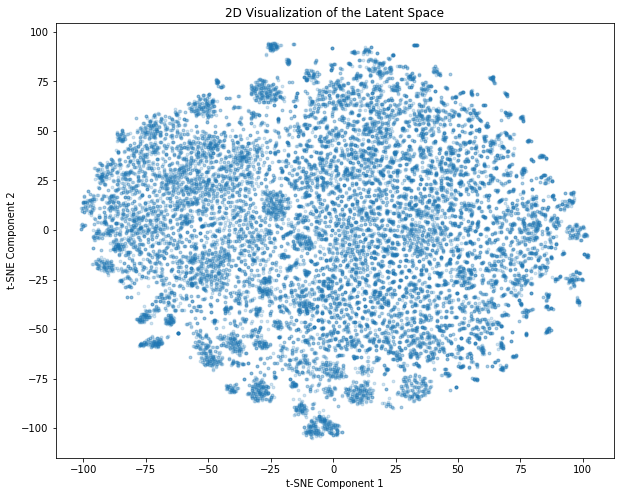

In [22]:
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=8, alpha=0.2)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D Visualization of the Latent Space')
plt.show()

In [23]:
def unicode_to_character(unicode_str):
    return chr(int(unicode_str, 16))

hover_text = []
for filename in dataset.file_names:  # Adjust this based on how you can access filenames
    unicode_str = filename.split('.')[0]  # Assuming filename format is 'UNICODE.txt'
    character = unicode_to_character(unicode_str)
    hover_text.append(character)

In [24]:
import plotly.express as px

# Assuming latent_2d is your t-SNE reduced coordinates
fig = px.scatter(x=latent_2d[:, 0], y=latent_2d[:, 1], 
                 hover_data=[hover_text], 
                 title='Interactive Latent Space Visualization with Chinese Characters')

# Adjusting marker size
fig.update_traces(marker=dict(size=3, opacity=0.2))  # You can change the size as needed

# Adjusting the plot to be square
fig.update_layout(
    xaxis=dict(
        constrain='domain'  # This makes the x-axis scale equal to the y-axis
    ),
    yaxis=dict(
        scaleanchor='x',
        scaleratio=1
    )
)

fig.show()

In [25]:
tsne3d = TSNE(n_components=3, random_state=42)
latent_3d = tsne3d.fit_transform(latent_vectors)  # latent_vectors from your VAE's latent space

In [26]:
import plotly.express as px

fig = px.scatter_3d(
    x=latent_3d[:, 0], 
    y=latent_3d[:, 1], 
    z=latent_3d[:, 2], 
    hover_data=[hover_text],
    title='3D Visualization of Latent Space with Chinese Characters'
)

# Adjusting marker size
fig.update_traces(marker=dict(size=2, opacity=0.2))  # You can change the size as needed

fig.show()